In [16]:
import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
sns.set_theme(context='notebook', style='darkgrid', palette='twilight', font='sans-serif', font_scale=1, color_codes=True, rc=None)

## Imporing Data

In [17]:
data = pd.read_csv("bengaluru_house_prices.csv")
pd.set_option('display.max_columns', None)
data.head(3)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00


## Data Cleaning

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [19]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7496 entries, 0 to 13318
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     7496 non-null   object 
 1   availability  7496 non-null   object 
 2   location      7496 non-null   object 
 3   size          7496 non-null   object 
 4   society       7496 non-null   object 
 5   total_sqft    7496 non-null   object 
 6   bath          7496 non-null   float64
 7   balcony       7496 non-null   float64
 8   price         7496 non-null   float64
dtypes: float64(3), object(6)
memory usage: 585.6+ KB


In [20]:
for column in data.columns:
    print(column)
    print("\t",data[column].unique())


area_type
	 ['Super built-up  Area' 'Plot  Area' 'Built-up  Area' 'Carpet  Area']
availability
	 ['19-Dec' 'Ready To Move' '18-Nov' '17-Oct' '21-Dec' '19-Sep' '20-Sep'
 '18-Mar' '18-Apr' '20-Aug' '19-Mar' '17-Sep' '17-Aug' '19-Apr' '22-Dec'
 '18-Aug' '19-Jan' '17-Jul' '18-Jul' '18-May' '18-Dec' '21-Jun' '18-Sep'
 '17-May' '17-Jun' '18-Oct' '21-May' '20-Dec' '18-Jun' '16-Mar' '22-Jun'
 '17-Dec' '21-Feb' '19-May' '17-Nov' '20-Oct' '20-Jun' '18-Feb' '19-Feb'
 '21-Oct' '21-Jan' '17-Mar' '19-Jun' '17-Apr' '22-May' '19-Oct' '21-Jul'
 '21-Nov' '21-Mar' '19-Jul' '20-Jan' '21-Sep' '18-Jan' '20-Mar' '19-Nov'
 '15-Jun' '19-Aug' '20-May' '20-Nov' '20-Jul' '20-Feb' '15-Dec' '21-Aug'
 '16-Oct' '22-Nov' '16-Dec' '15-Aug' '17-Jan' '16-Nov' '20-Apr' '22-Jan'
 '16-Jan' '17-Feb' '14-Jul']
location
	 ['Electronic City Phase II' 'Chikka Tirupathi' 'Lingadheeranahalli'
 'Whitefield' '7th Phase JP Nagar' 'Sarjapur' 'Mysore Road'
 'Bisuvanahalli' 'Raja Rajeshwari Nagar' 'Ramakrishnappa Layout'
 'Binny Pete' '

In [21]:
# keep only numerica value
data['size'] =data['size'].apply(lambda x: x.split(' ')[0])
data['size'].unique()

array(['2', '4', '3', '1', '5', '11', '9', '6', '7'], dtype=object)

In [22]:
# merge phase road etc
pattern = r'\d+(st|nd|rd|th)\s'
def extract_location(location):
    location = re.sub(pattern, '', location)  # Remove patterns like "1st", "2nd", etc.
    location = re.sub(r'\b(phase|sector|road|zone|layout|avenue|colony)\b.*$', '', location, flags=re.IGNORECASE)  # Remove specified terms and anything after them
    return location.strip()
data['location'] = data['location'].apply(lambda x: extract_location(x))

In [23]:
len(data['location'].unique()) # length before spelling correction

598

In [24]:
from collections import Counter
from fuzzywuzzy import fuzz

In [25]:
def identify_misspellings(locations, known_locations, threshold=80):
    misspellings = {}

    for location in locations:
        found = False
        for known_location in known_locations:
            # Calculate Levenshtein distance
            similarity = fuzz.ratio(location, known_location)
            if similarity > threshold:
                found = True
                misspellings[location] = known_location
                break
        if not found:
            misspellings[location] = None  # Mark as not found

    return misspellings

Geting known locations

In [26]:
import requests
from bs4 import BeautifulSoup

# Wikipedia URL
url = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Bangalore"

response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

tables = soup.find_all("table", {"class": "wikitable"})

In [27]:
known_names = []
for table in tables:
   
    neighborhood_names = []
    for row in table.find_all("tr")[1:]:
        name = row.find("td").text.strip()
        neighborhood_names.append(name)

    for name in neighborhood_names:
        known_names.append(name)

In [28]:
misspelled_loc = identify_misspellings(data['location'].unique(),known_names)

In [29]:
for misspelled, corrected in misspelled_loc.items():
    if corrected:
        data['location'] = data['location'].replace(misspelled, corrected)

In [30]:
len(data['location'].unique())# after correction

581

## Exploratory Data Analysis


In [31]:
from sklearn.preprocessing import LabelEncoder
import scipy.stats as ss

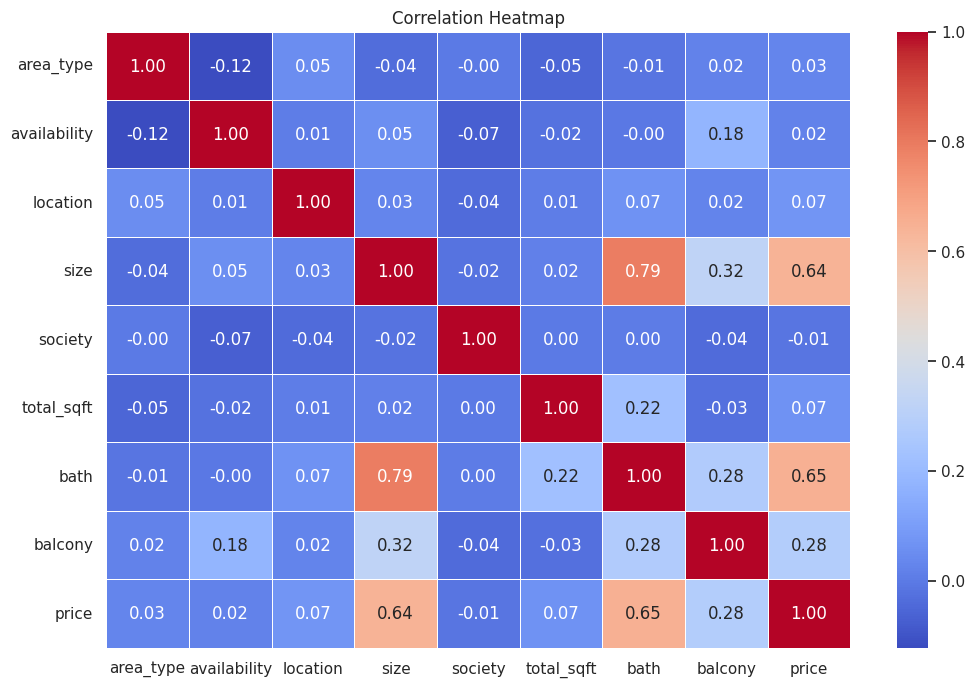

In [32]:
# Convert categorical variables to numerical labels
label_encoder = LabelEncoder()
data_encoded = data.apply(label_encoder.fit_transform)

corr_matrix = data_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Distribution Of Features in Data Columns

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

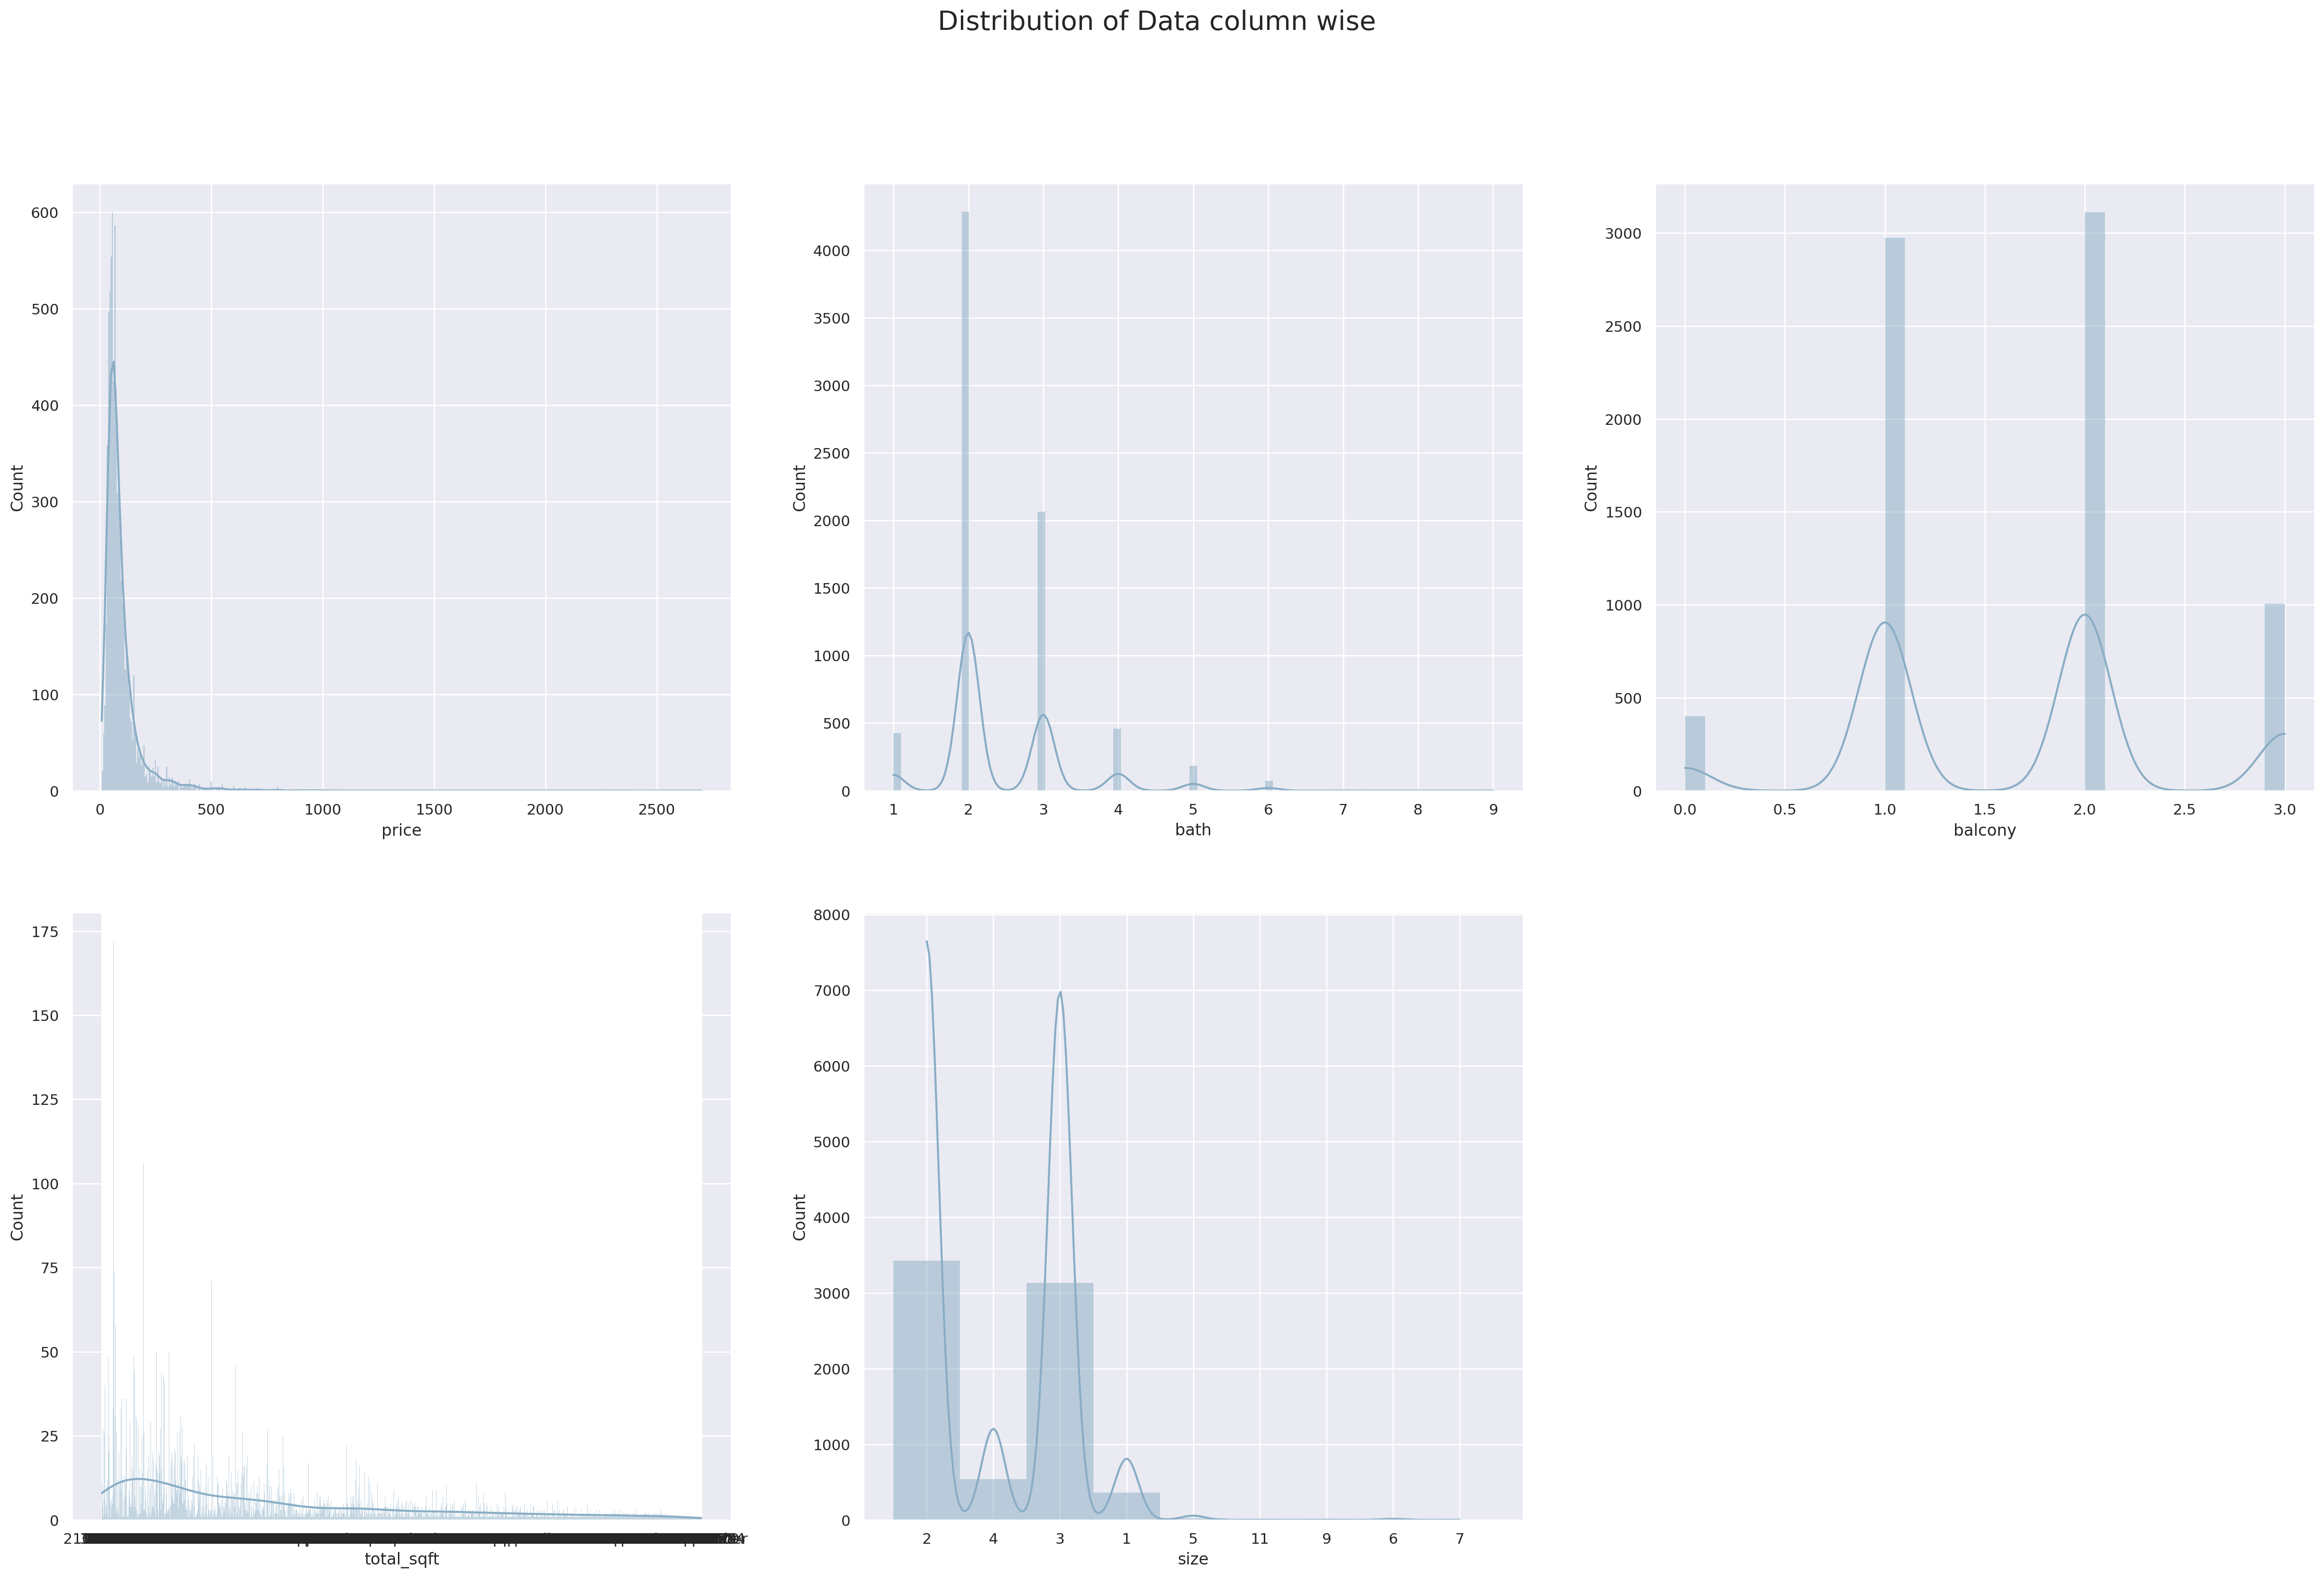

In [33]:
plt.figure(figsize=(30, 18), dpi=200)

plt.subplot(2,3,1)
sns.histplot(data["price"], linewidth=0,kde=True)

plt.subplot(2,3,2)
sns.histplot(data["bath"], linewidth=0,kde=True)

plt.subplot(2,3,3)
sns.histplot(data["balcony"], linewidth=0,kde=True)

plt.subplot(2,3,4)
sns.histplot(data["total_sqft"], linewidth=0,kde=True)

plt.subplot(2,3,5)
sns.histplot(data["size"], linewidth=0,kde=True)

plt.suptitle("Distribution of Data column wise", fontsize=20)
plt.show()

### Plotting Features column vs Target column

In [34]:
data['size'] =data['size'].apply(lambda x: int(x))

def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        if '-' in value:
            lower, upper = map(float, value.split('-'))
            return (lower + upper) / 2
        else:
            return None  

data['total_sqft'] = data['total_sqft'].apply(convert_to_float)

<Axes: xlabel='size', ylabel='price'>

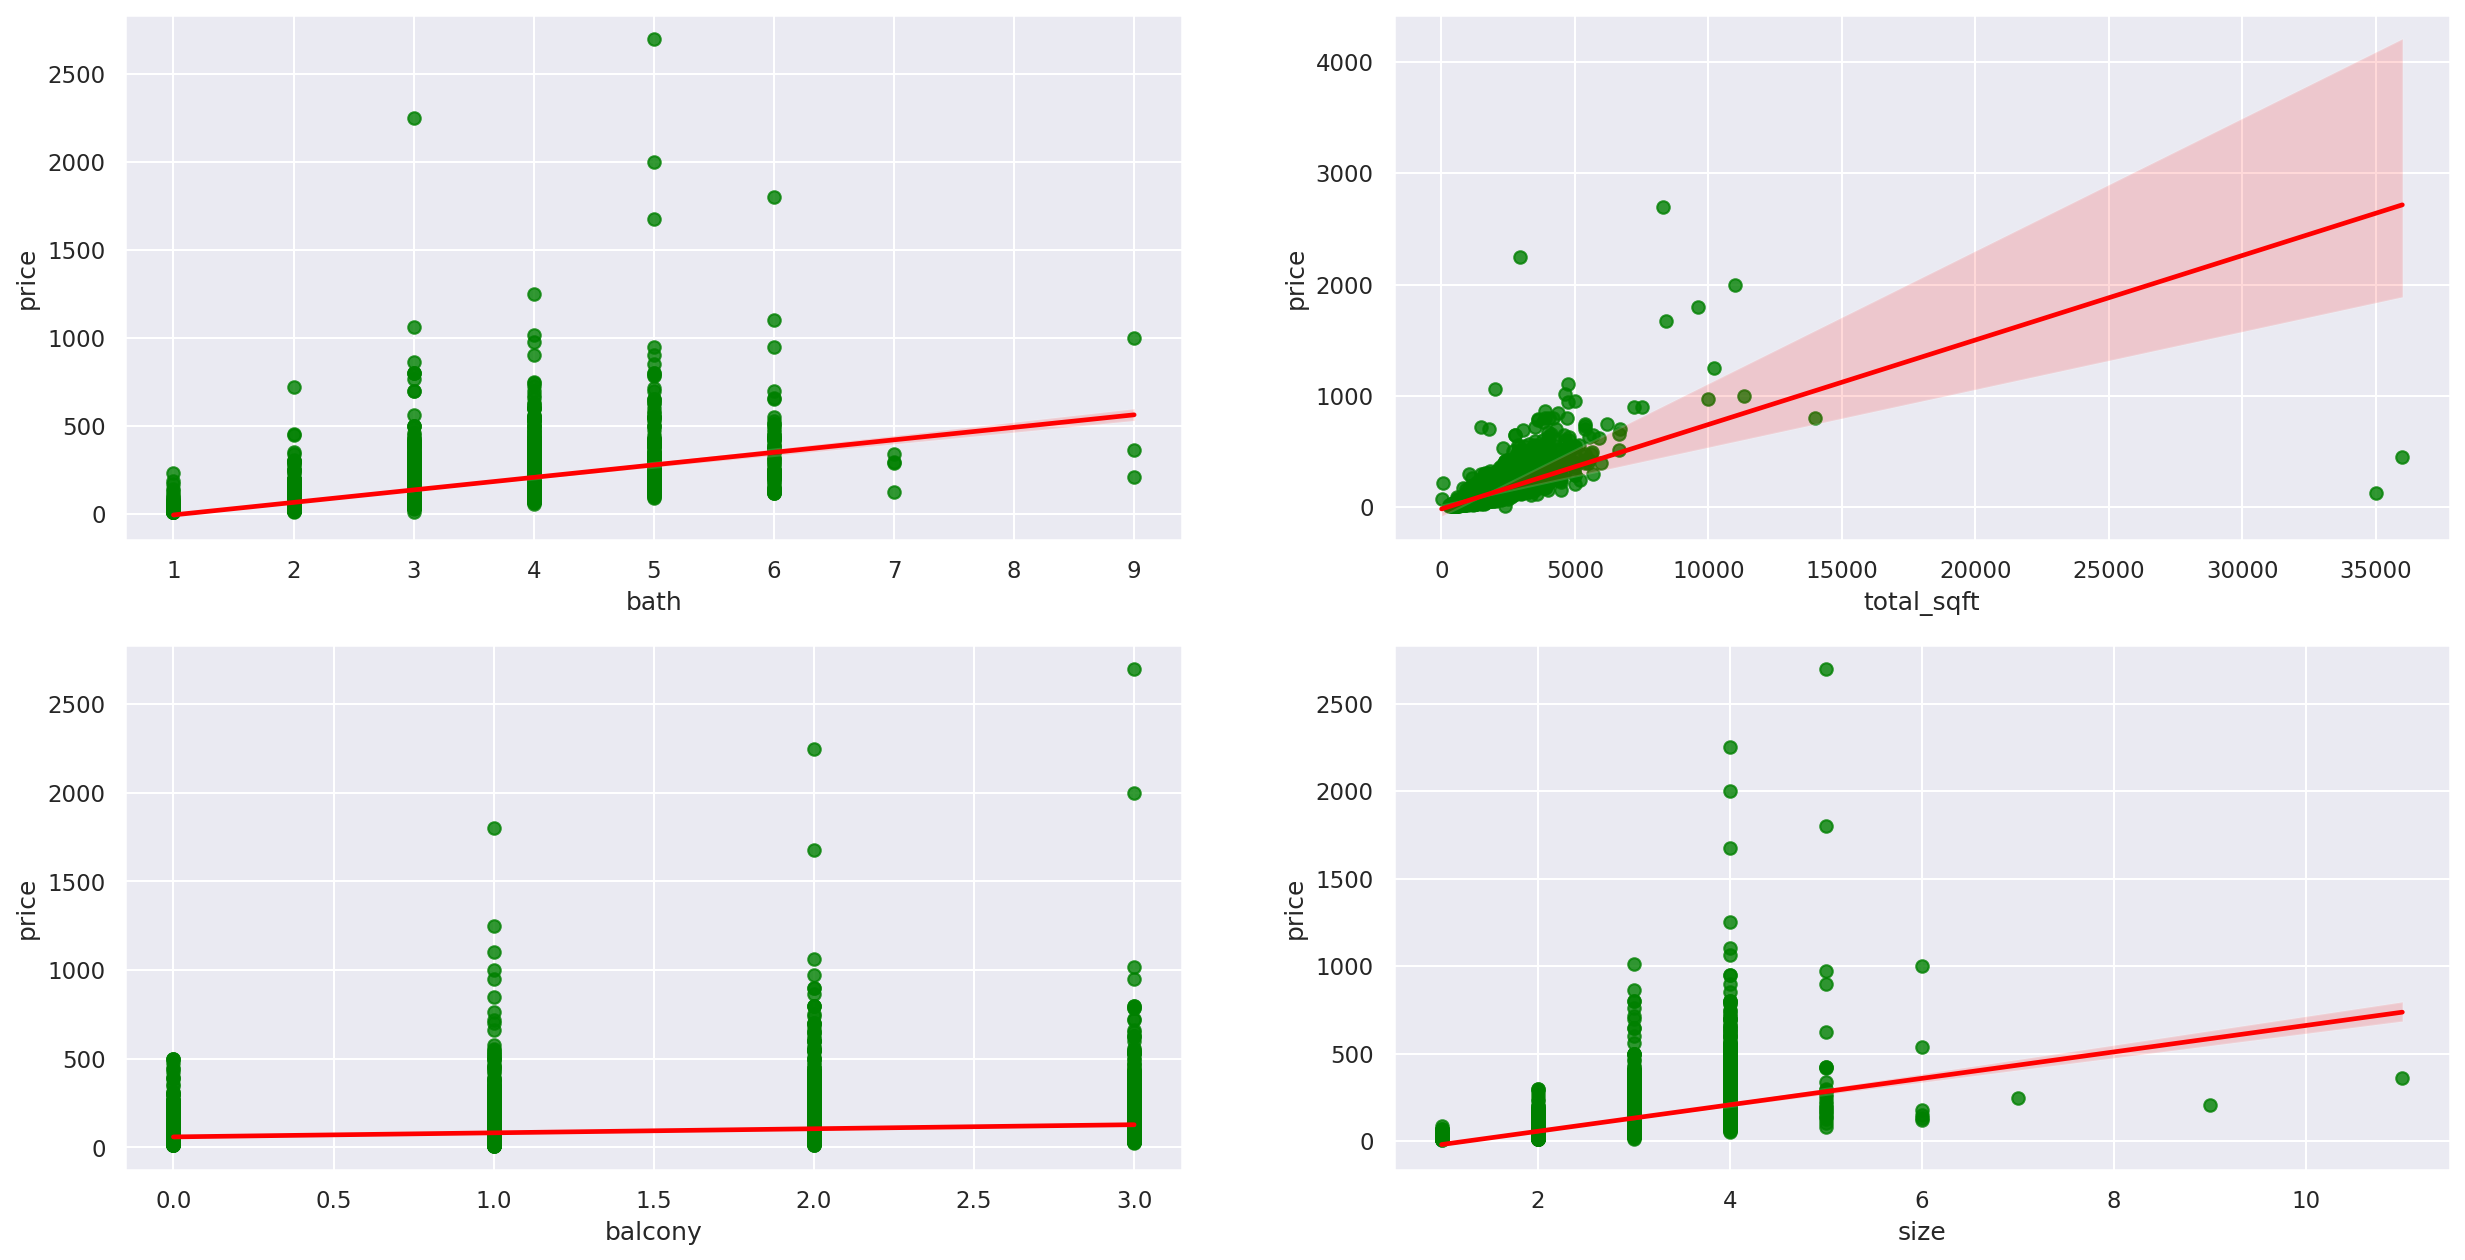

In [35]:
plt.figure(figsize=(20, 10), dpi=150)

plt.subplot(2,2,1)
sns.regplot(x=data["bath"], y=data["price"], scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.subplot(2,2,2)
sns.regplot(x=data["total_sqft"], y=data["price"], scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.subplot(2,2,3)
sns.regplot(x=data["balcony"], y=data["price"], scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.subplot(2,2,4)
sns.regplot(x=data["size"], y=data["price"], scatter_kws={"color": "green"}, line_kws={"color": "red"})

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7496 entries, 0 to 13318
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     7496 non-null   object 
 1   availability  7496 non-null   object 
 2   location      7496 non-null   object 
 3   size          7496 non-null   int64  
 4   society       7496 non-null   object 
 5   total_sqft    7481 non-null   float64
 6   bath          7496 non-null   float64
 7   balcony       7496 non-null   float64
 8   price         7496 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 585.6+ KB


<Axes: xlabel='location', ylabel='price'>

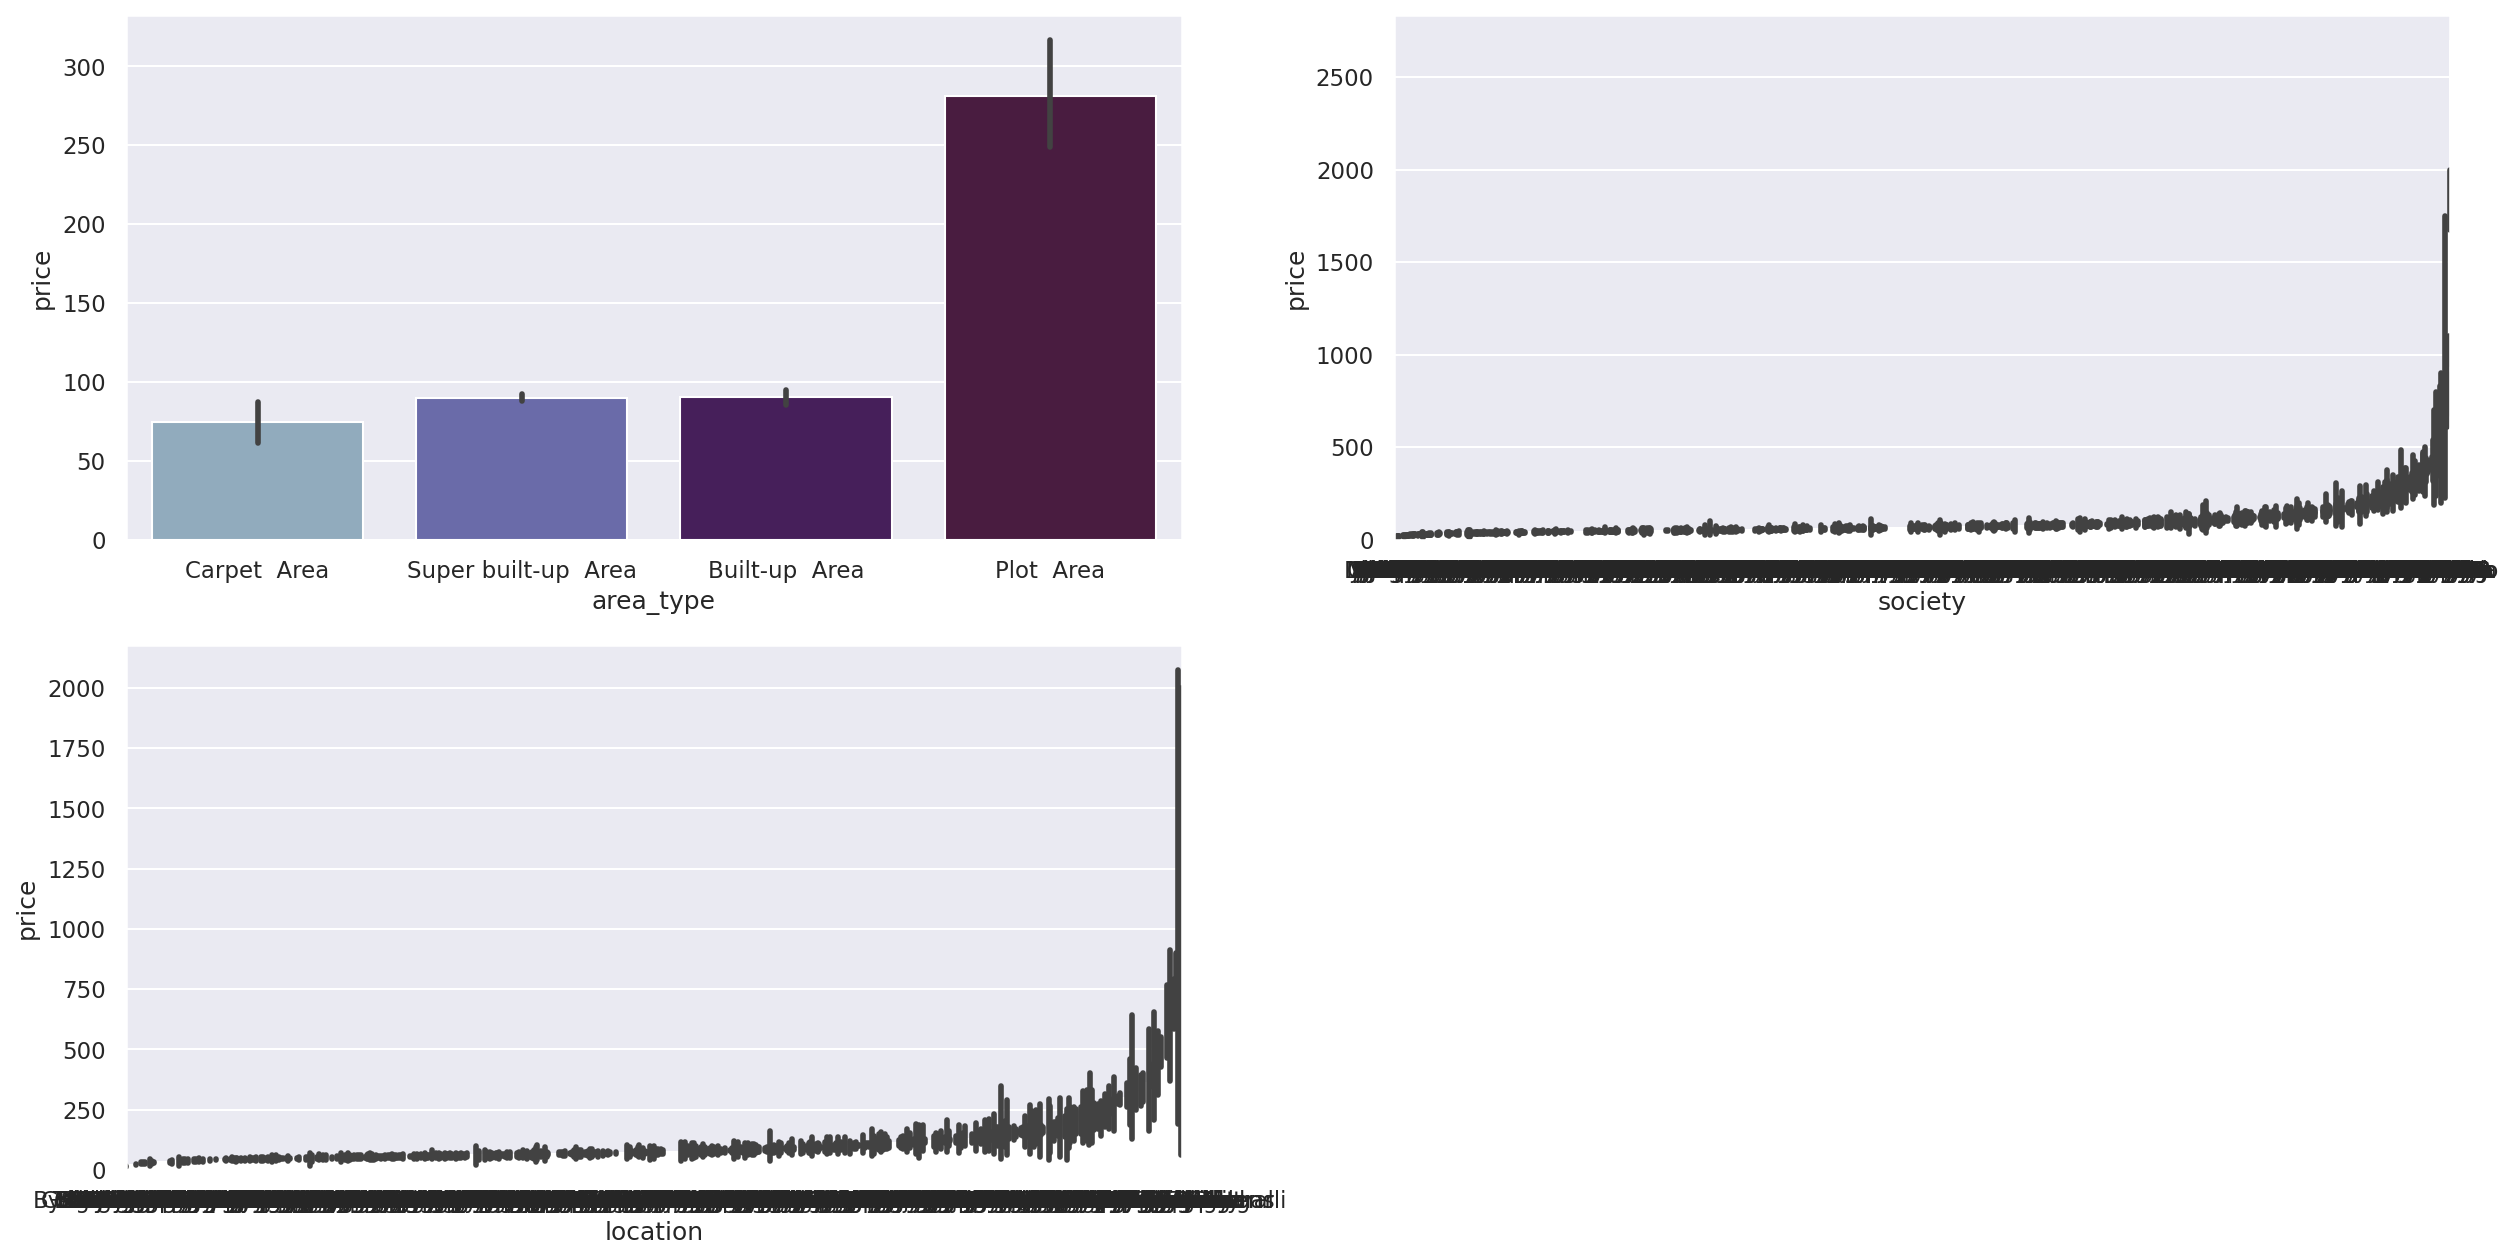

In [37]:
plt.figure(figsize=(20, 10), dpi=150)

plt.subplot(2,2,1)
sns.barplot(x=data.area_type,y=data.price,order=data.groupby('area_type')['price'].mean().reset_index().sort_values('price')['area_type'])

plt.subplot(2,2,2)
sns.barplot(x=data.society,y=data.price,order=data.groupby('society')['price'].mean().reset_index().sort_values('price')['society'])

plt.subplot(2,2,3)
sns.barplot(x=data.location,y=data.price,order=data.groupby('location')['price'].mean().reset_index().sort_values('price')['location'])


In [38]:
data.drop(['society',"availability"],axis=1, inplace=True)

## Remove Outliers

In [39]:
def remove_outliers(df, cols, threshold=1.5):
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Specify numerical columns to check for outliers
numerical_cols = ['size', 'total_sqft', 'bath', 'balcony', 'price']

# Remove outliers from the specified numerical columns
data = remove_outliers(data, numerical_cols)

## Encoding

In [40]:
df = data.copy()

In [41]:
location_means = df.groupby('location')['price'].mean()

df['location_encoded'] = df['location'].map(location_means)

df.drop('location', axis=1, inplace=True)

In [42]:
area_type_means = df.groupby('area_type')['price'].mean()

df['area_type_encoded'] = df['area_type'].map(area_type_means)

df.drop('area_type', axis=1, inplace=True)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6580 entries, 0 to 13317
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   size               6580 non-null   int64  
 1   total_sqft         6580 non-null   float64
 2   bath               6580 non-null   float64
 3   balcony            6580 non-null   float64
 4   price              6580 non-null   float64
 5   location_encoded   6580 non-null   float64
 6   area_type_encoded  6580 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 411.2 KB


In [44]:
df.head()

,size,total_sqft,bath,balcony,price,location_encoded,area_type_encoded
0,2,1056.0,2.0,1.0,39.07,51.346333,70.764672
3,3,1521.0,3.0,1.0,95.00,115.348261,70.764672
5,2,1170.0,2.0,1.0,38.00,72.232812,70.764672
12,2,1000.0,2.0,1.0,38.00,79.524110,70.764672
14,3,2250.0,3.0,2.0,148.00,74.664896,106.679540


## Linear models

### Split into test and train

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
df.columns

Index(['size', 'total_sqft', 'bath', 'balcony', 'price', 'location_encoded',
       'area_type_encoded'],
      dtype='object')

In [47]:
input_cols = ['size', 'total_sqft', 'bath', 'balcony', 'location_encoded','area_type_encoded']

target_cols = 'price'

input = df[input_cols].copy()
target = df[target_cols].copy()


In [48]:
X_train, X_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state = 7)

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

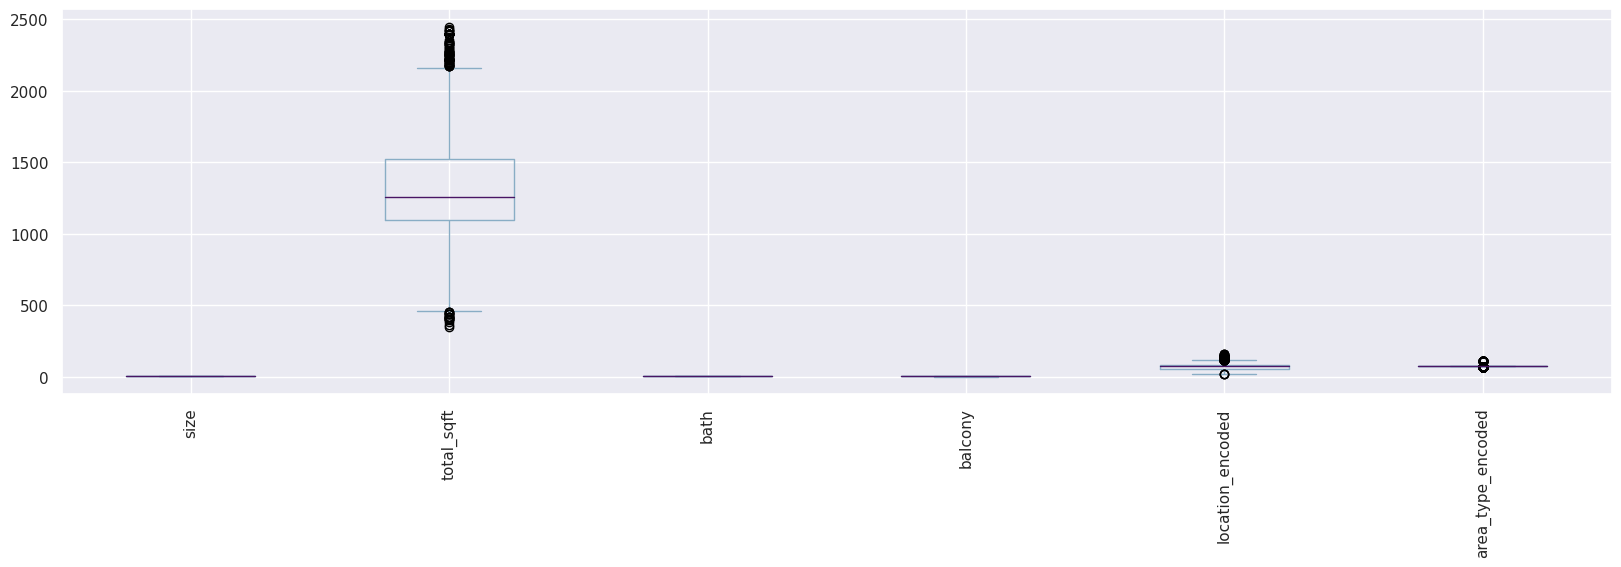

In [50]:
pd.DataFrame(X_train, columns=X_train.columns).plot.box(figsize=(20,5), rot=90)
plt.show()

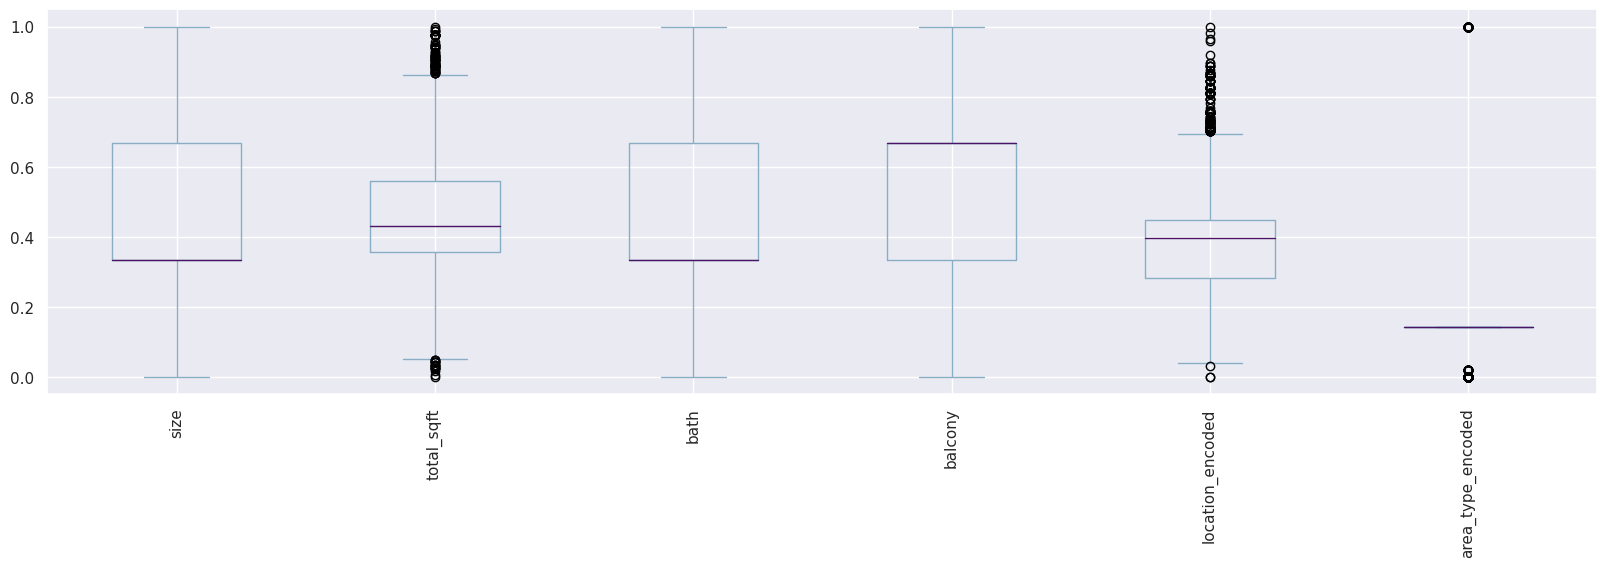

In [51]:
mm = MinMaxScaler().fit(X_train)
X_train_mm = mm.transform(X_train)
X_train_mm = pd.DataFrame(X_train_mm, columns=X_train.columns)
X_test_mm = mm.transform(X_test)
X_test_mm = pd.DataFrame(X_test_mm, columns=X_test.columns)
X_train_mm.plot.box(figsize=(20,5), rot=90)
plt.show()

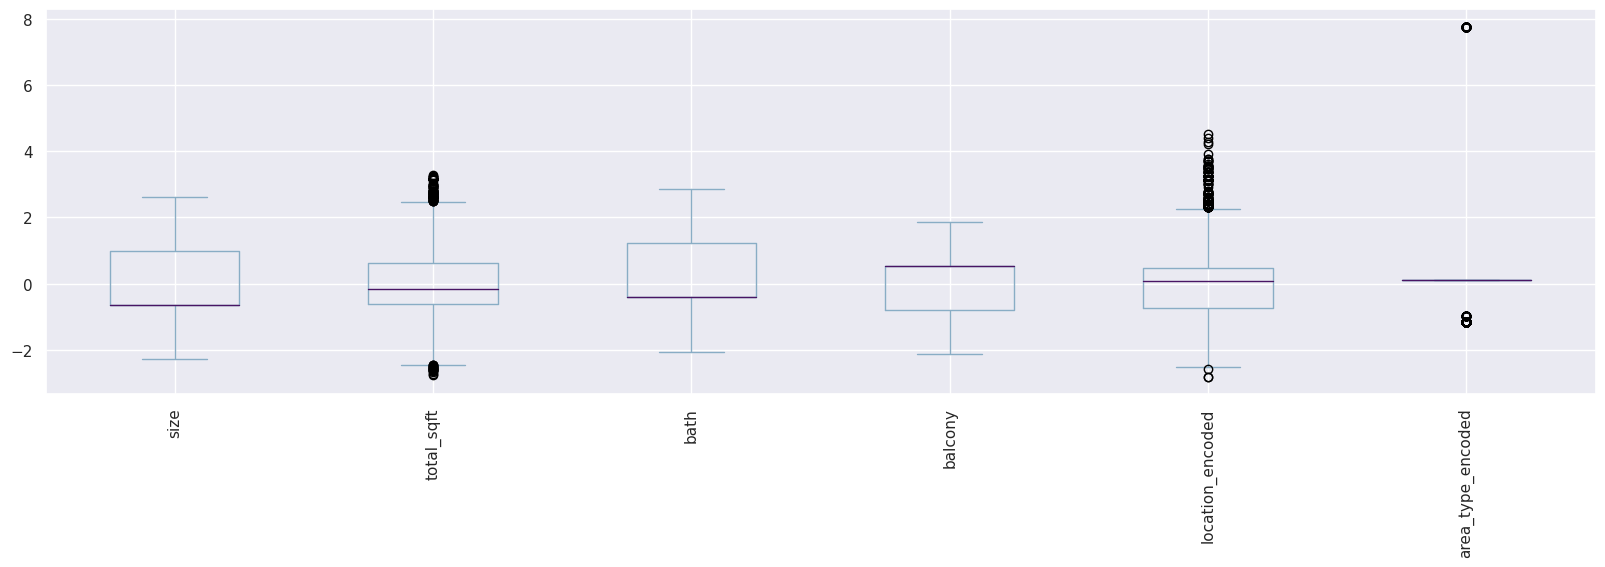

In [52]:
ss = StandardScaler().fit(X_train)
X_train_ss = ss.transform(X_train)
X_train_ss = pd.DataFrame(X_train_ss, columns=X_train.columns)
X_test_ss = ss.transform(X_test)
X_test_ss = pd.DataFrame(X_test_ss, columns=X_test.columns)
X_train_ss.plot.box(figsize=(20,5), rot=90)
plt.show()

## Model Training

In [53]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.svm import SVR

### LinearRegression

In [63]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))

# lr = LinearRegression()
lr.fit(X_train_ss, y_train)
y_predlrss = lr.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_predlrss))

# lr = LinearRegression()
lr.fit(X_train_mm, y_train)
y_predlrmm = lr.predict(X_test_mm)
print('R2- SCORE(Minmaxscaled):', metrics.r2_score(y_test,y_predlrmm))

r2_lr = metrics.r2_score(y_test, y_pred)
r2_lr_ss = metrics.r2_score(y_test, y_predlrss)
r2_lr_mm = metrics.r2_score(y_test, y_predlrmm)

# Create a list of lists for the data
new_data = [
    ["LinearRegression", r2_lr,r2_lr_mm,r2_lr_ss]
]

columns = ['model','R2',"R2 -MinMaxScaler","R2 - StandardScaler"]
results = pd.DataFrame(new_data, columns=columns)

R2- SCORE: 0.7133396680398164
R2- SCORE(Standardscaler): 0.7133396680398164
R2- SCORE(Minmaxscaled): 0.7133396680398163


In [64]:
results.head()

,model,R2,R2 -MinMaxScaler,R2 - StandardScaler
0,LinearRegression,0.71334,0.71334,0.71334


### KNN

In [57]:
from sklearn.neighbors import KNeighborsRegressor

Orange and Blue depict RSME for MinMaxScaler and Standard Sacalr


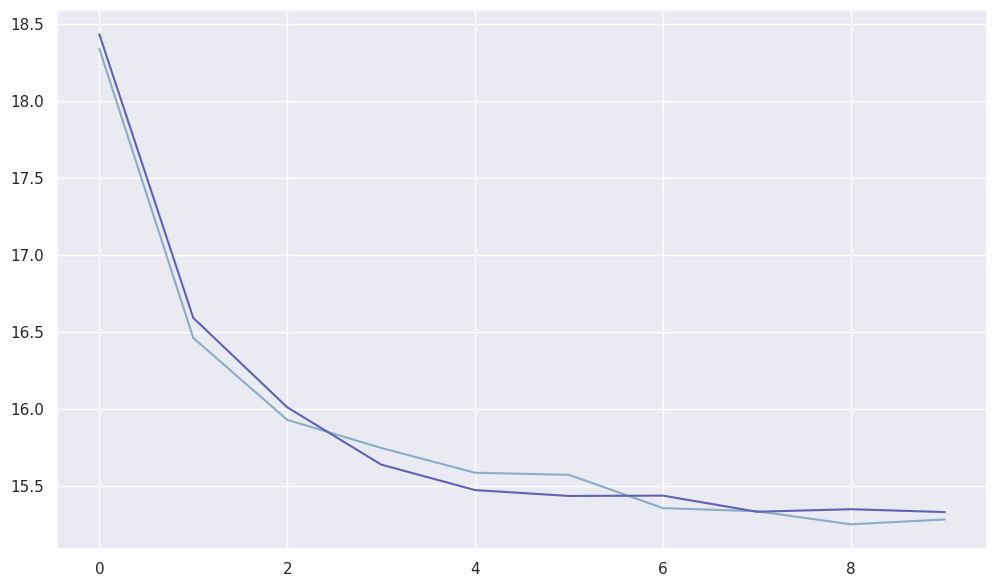

In [58]:
rmse_val = []
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train_mm, y_train)
    pred=model.predict(X_test_mm)
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val.append(error)
curve = pd.DataFrame(rmse_val)

rmse_val1 = []
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train_ss, y_train)
    pred=model.predict(X_test_ss)
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val1.append(error)
curve1 = pd.DataFrame(rmse_val1)

print('Orange and Blue depict RSME for MinMaxScaler and Standard Sacalr')
plt.figure(figsize=(12,7))
plt.plot(curve)
plt.plot(curve1)
plt.show()

### Tree Based

In [59]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import tree
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

## DecisionTree

In [65]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
# Define the parameter grid for grid search
param_grid = {
    'max_depth': [None, 5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create the GridSearchCV object
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='r2')

# Perform the grid search on the original dataset (X_train, y_train)
grid_search.fit(X_train, y_train)

# Get the best estimator and its corresponding R2 score
best_dt = grid_search.best_estimator_
best_dt_r2 = grid_search.best_score_
print("Best Parameters:", grid_search.best_params_)

y_pred_dt = best_dt.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_dt))

best_dt.fit(X_train_mm, y_train)
y_pred_dtmm = best_dt.predict(X_test_mm)
print('R2- SCORE(Minmaxscaled):', metrics.r2_score(y_test,y_pred_dtmm))

best_dt.fit(X_train_ss, y_train)
y_pred_dtss = best_dt.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_dtss))

r2_dt = metrics.r2_score(y_test, y_pred_dt)
r2_dt_ss = metrics.r2_score(y_test, y_pred_dtss)
r2_dt_mm = metrics.r2_score(y_test, y_pred_dtmm)

new_row = pd.DataFrame({
    'model': ["DecisionTree"],
    'R2': [r2_dt],
    'R2 -MinMaxScaler': [r2_dt_mm],
    'R2 - StandardScaler': [r2_dt_ss]
})

results = pd.concat([results, new_row], ignore_index=True)
results.head()

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
R2- SCORE: 0.7393288813651888
R2- SCORE(Minmaxscaled): 0.7393809172715946
R2- SCORE(Standardscaler): 0.7393809172715946


,model,R2,R2 -MinMaxScaler,R2 - StandardScaler
0,LinearRegression,0.713340,0.713340,0.713340
1,DecisionTree,0.739329,0.739381,0.739381


## Ensamble Learning

## Voting

In [72]:
param_grid_dt = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'max_features': [1.0, 'sqrt']
}

param_grid_xg = {
    'learning_rate': [0.5, 0.7, 1.0],
    'n_estimators': [50, 100, 200]
}

grid_search_dt = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, cv=5)
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5)
grid_search_xg = GridSearchCV(xgb.XGBRegressor(verbosity=0), param_grid_xg, cv=5)

grid_search_dt.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_xg.fit(X_train, y_train)

best_dt = grid_search_dt.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_xg = grid_search_xg.best_estimator_

print("Best Parameters dt:", grid_search_dt.best_params_)
print("Best Parameters rf:", grid_search_rf.best_params_)
print("Best Parameters xg:", grid_search_xg.best_params_)

vr = VotingRegressor([('dt', best_dt), ('knn', knn), ('lr', lr), ('rf', best_rf), ('xg', best_xg), ('gbr', gbr), ('etr', etr)])

vr.fit(X_train, y_train)
y_pred_vr = vr.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test, y_pred_vr))

grid_search_dt.fit(X_train_mm, y_train)
grid_search_rf.fit(X_train_mm, y_train)
grid_search_xg.fit(X_train_mm, y_train)

best_dt = grid_search_dt.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_xg = grid_search_xg.best_estimator_
vr = VotingRegressor([('dt', best_dt), ('knn', knn), ('lr', lr), ('rf', best_rf), ('xg', best_xg), ('gbr', gbr), ('etr', etr)])

vr.fit(X_train, y_train)
y_pred_dtmm = best_dt.predict(X_test_mm)
print('R2- SCORE(Minmaxscaled):', metrics.r2_score(y_test,y_pred_dtmm))

grid_search_dt.fit(X_train_ss, y_train)
grid_search_rf.fit(X_train_ss, y_train)
grid_search_xg.fit(X_train_ss, y_train)

best_dt = grid_search_dt.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_xg = grid_search_xg.best_estimator_
vr = VotingRegressor([('dt', best_dt), ('knn', knn), ('lr', lr), ('rf', best_rf), ('xg', best_xg), ('gbr', gbr), ('etr', etr)])

y_pred_dtss = best_dt.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_dtss))


r2_vr = metrics.r2_score(y_test, y_pred_vr)
r2_vr_ss = metrics.r2_score(y_test, y_pred_dtss)
r2_vr_mm = metrics.r2_score(y_test, y_pred_dtmm)

new_row = pd.DataFrame({
    'model': ["Voting Regressor"],
    'R2': [r2_vr],
    'R2 -MinMaxScaler': [r2_vr_mm],
    'R2 - StandardScaler': [r2_vr_ss]
})

results = pd.concat([results, new_row], ignore_index=True)
results.head()

Best Parameters dt: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Parameters rf: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}
Best Parameters xg: {'learning_rate': 0.5, 'n_estimators': 50}
R2- SCORE: 0.789381048855847
R2- SCORE(Minmaxscaled): 0.7393809172715946
R2- SCORE(Standardscaler): 0.7393809172715946


,model,R2,R2 -MinMaxScaler,R2 - StandardScaler
0,LinearRegression,0.713340,0.713340,0.713340
1,DecisionTree,0.739329,0.739381,0.739381
2,Voting Regressor,0.789385,-3.618993,-3.600831
3,Random Forest,0.791790,0.789643,0.790015
4,Voting Regressor,0.789188,-3.618993,-3.600831


### Random Forest

In [69]:
rf = RandomForestRegressor(n_estimators= 200, max_depth = 15, max_features='sqrt')
rf.fit(X_train, y_train);
y_pred_rf = rf.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_rf))

rf.fit(X_train_mm, y_train);
y_pred_rfmm = rf.predict(X_test_mm)
print('R2- SCORE(minmaxscaled):', metrics.r2_score(y_test,y_pred_rfmm))

rf.fit(X_train_ss, y_train);
y_pred_rfss = rf.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_rfss))

r2_rf = metrics.r2_score(y_test, y_pred_rf)
r2_rf_ss = metrics.r2_score(y_test, y_pred_rfss)
r2_rf_mm = metrics.r2_score(y_test, y_pred_rfmm)

new_row = pd.DataFrame({
    'model': ["Random Forest"],
    'R2': [r2_rf],
    'R2 -MinMaxScaler': [r2_rf_mm],
    'R2 - StandardScaler': [r2_rf_ss]
})

results = pd.concat([results, new_row], ignore_index=True)
results.head()

R2- SCORE: 0.7917895529647908
R2- SCORE(minmaxscaled): 0.7896430515220274
R2- SCORE(Standardscaler): 0.7900154141972687


,model,R2,R2 -MinMaxScaler,R2 - StandardScaler
0,LinearRegression,0.713340,0.713340,0.713340
1,DecisionTree,0.739329,0.739381,0.739381
2,Voting Regressor,0.789385,-3.618993,-3.600831
3,Random Forest,0.791790,0.789643,0.790015


### GradientBoostingRegressor

In [77]:

for lr in [0.1,0.3,0.5,0.8,1]:
  model= GradientBoostingRegressor(learning_rate=lr)
  model.fit(X_train, y_train)
  print("Learning rate : ", lr, " Train score : ", model.score(X_train,y_train), " Test score : ", model.score(X_test,y_test))


Learning rate :  0.1  Train score :  0.7922307302275546  Test score :  0.7686938344165966
Learning rate :  0.3  Train score :  0.823671795876552  Test score :  0.7676938778497822
Learning rate :  0.5  Train score :  0.8435060019931027  Test score :  0.7618839469776079
Learning rate :  0.8  Train score :  0.8560686435088334  Test score :  0.7431160082570092
Learning rate :  1  Train score :  0.8648081971662717  Test score :  0.6925082617812901


In [78]:
gbr = GradientBoostingRegressor(learning_rate=.1)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_gbr))

gbr.fit(X_train_mm, y_train)
y_pred_gbrmm = gbr.predict(X_test_mm)
print('R2- SCORE(MinMaxScaler):', metrics.r2_score(y_test,y_pred_gbrmm))

gbr.fit(X_train_ss, y_train)
y_pred_gbrss = gbr.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_gbrss))

r2_gbr= metrics.r2_score(y_test, y_pred_gbr)
r2_gbr_ss = metrics.r2_score(y_test, y_pred_gbrss)
r2_gbr_mm = metrics.r2_score(y_test, y_pred_gbrmm)

new_row = pd.DataFrame({
    'model': ["GradientBoostingRegressor"],
    'R2': [r2_gbr],
    'R2 -MinMaxScaler': [r2_gbr_mm],
    'R2 - StandardScaler': [r2_gbr_ss]
})

results = pd.concat([results, new_row], ignore_index=True)
print(results)

R2- SCORE: 0.76868991424753
R2- SCORE(MinMaxScaler): 0.7689281355137674
R2- SCORE(Standardscaler): 0.7691088534656528
                       model        R2  R2 -MinMaxScaler  R2 - StandardScaler
0           LinearRegression  0.713340          0.713340             0.713340
1               DecisionTree  0.739329          0.739381             0.739381
2           Voting Regressor  0.789385         -3.618993            -3.600831
3              Random Forest  0.791790          0.789643             0.790015
4           Voting Regressor  0.789188         -3.618993            -3.600831
5           Voting Regressor  0.790102         -3.618993            -3.600831
6           Voting Regressor  0.789381          0.739381             0.739381
7  GradientBoostingRegressor  0.768690          0.768928             0.769109


### XG Boost

In [79]:
xg = xgb.XGBRegressor(learning_rate = .5, n_estimators=50, verbosity = 0)
xg.fit(X_train, y_train)
y_pred_xg = xg.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_xg))

xg.fit(X_train_mm, y_train)
y_pred_xgmm = xg.predict(X_test_mm)
print('R2- SCORE(MinMaxScaler):', metrics.r2_score(y_test,y_pred_xgmm))

xg.fit(X_train_ss, y_train)
y_pred_xgss = xg.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_xgss))

r2_xg= metrics.r2_score(y_test, y_pred_xg)
r2_xg_ss = metrics.r2_score(y_test, y_pred_xgss)
r2_xg_mm = metrics.r2_score(y_test, y_pred_xgmm)

new_row = pd.DataFrame({
    'model': ["XG Boost"],
    'R2': [r2_xg],
    'R2 -MinMaxScaler': [r2_xg_mm],
    'R2 - StandardScaler': [r2_xg_ss]
})

results = pd.concat([results, new_row], ignore_index=True)
print(results)

R2- SCORE: 0.7788165491912282
R2- SCORE(MinMaxScaler): 0.7788165491912282
R2- SCORE(Standardscaler): 0.7788165491912282
                       model        R2  R2 -MinMaxScaler  R2 - StandardScaler
0           LinearRegression  0.713340          0.713340             0.713340
1               DecisionTree  0.739329          0.739381             0.739381
2           Voting Regressor  0.789385         -3.618993            -3.600831
3              Random Forest  0.791790          0.789643             0.790015
4           Voting Regressor  0.789188         -3.618993            -3.600831
5           Voting Regressor  0.790102         -3.618993            -3.600831
6           Voting Regressor  0.789381          0.739381             0.739381
7  GradientBoostingRegressor  0.768690          0.768928             0.769109
8                   XG Boost  0.778817          0.778817             0.778817


In [80]:
results.reset_index(inplace=True)
results.set_index('model', inplace=True)
sorted_df = results.sort_values(by=results.columns.tolist(), axis=0, ascending=False)
print(sorted_df)

                           index        R2  R2 -MinMaxScaler  \
model                                                          
XG Boost                       8  0.778817          0.778817   
GradientBoostingRegressor      7  0.768690          0.768928   
Voting Regressor               6  0.789381          0.739381   
Voting Regressor               5  0.790102         -3.618993   
Voting Regressor               4  0.789188         -3.618993   
Random Forest                  3  0.791790          0.789643   
Voting Regressor               2  0.789385         -3.618993   
DecisionTree                   1  0.739329          0.739381   
LinearRegression               0  0.713340          0.713340   

                           R2 - StandardScaler  
model                                           
XG Boost                              0.778817  
GradientBoostingRegressor             0.769109  
Voting Regressor                      0.739381  
Voting Regressor                     -3.600831  
V

In [82]:
results

,index,R2,R2 -MinMaxScaler,R2 - StandardScaler
model,,,,
LinearRegression,0,0.713340,0.713340,0.713340
DecisionTree,1,0.739329,0.739381,0.739381
Voting Regressor,2,0.789385,-3.618993,-3.600831
Random Forest,3,0.791790,0.789643,0.790015
Voting Regressor,4,0.789188,-3.618993,-3.600831
Voting Regressor,5,0.790102,-3.618993,-3.600831
Voting Regressor,6,0.789381,0.739381,0.739381
GradientBoostingRegressor,7,0.768690,0.768928,0.769109
XG Boost,8,0.778817,0.778817,0.778817


## Visualize performance

In [83]:
dt = DecisionTreeRegressor()
knn = KNeighborsRegressor(n_neighbors=100)
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators= 100, max_depth = 15, max_features='sqrt')
xg = xgb.XGBRegressor(learning_rate = .7, n_estimators=100, verbosity = 0)
gbr = GradientBoostingRegressor(learning_rate=.5)

vr = VotingRegressor([('dt', dt), ('knn', knn), ('lr', lr), ('rf', rf), ('xg', xg), ('gbr', gbr)])
vr.fit(X_train_ss, y_train);
y_pred_vrss = vr.predict(X_test_ss)


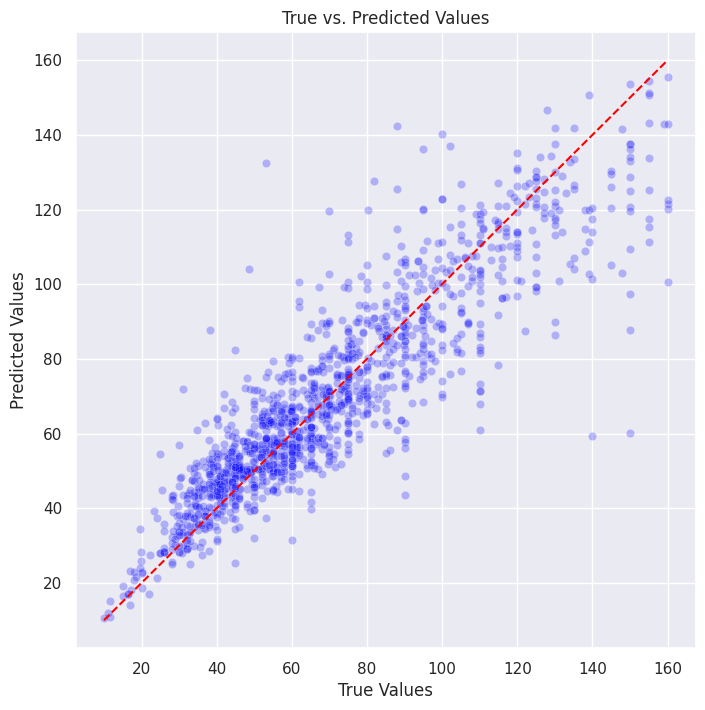

In [84]:
pred_df = pd.DataFrame({'True Values': y_test, 'Predicted Values': y_pred_vrss})

# Plot using Seaborn
plt.figure(figsize=(8, 8))
sns.scatterplot(data=pred_df, x='True Values', y='Predicted Values', color='blue', alpha=0.25)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.title('True vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


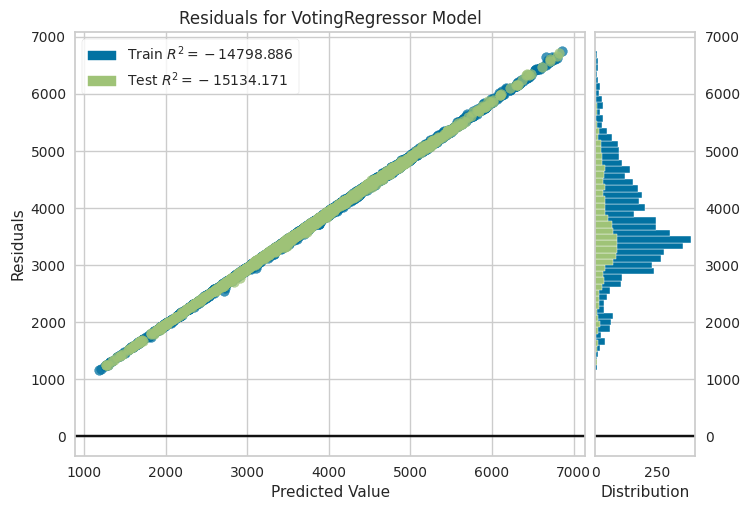

<Axes: title={'center': 'Residuals for VotingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [85]:
from yellowbrick.regressor import ResidualsPlot

# Create a ResidualsPlot
visualizer = ResidualsPlot(vr)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw residuals plot
visualizer.show()


DecisionTreeRegressor()


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


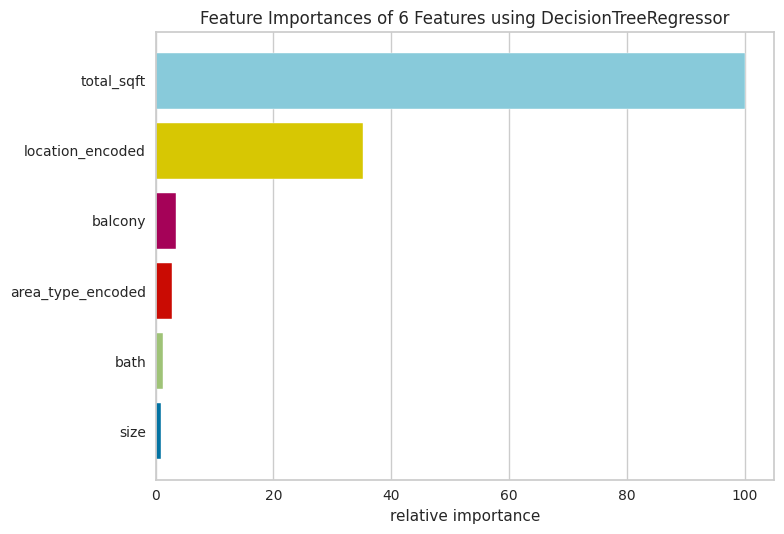

KNeighborsRegressor(n_neighbors=100)
Estimator knn does not support feature importances.
LinearRegression()
Estimator lr does not support feature importances.
RandomForestRegressor(max_depth=15, max_features='sqrt')


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


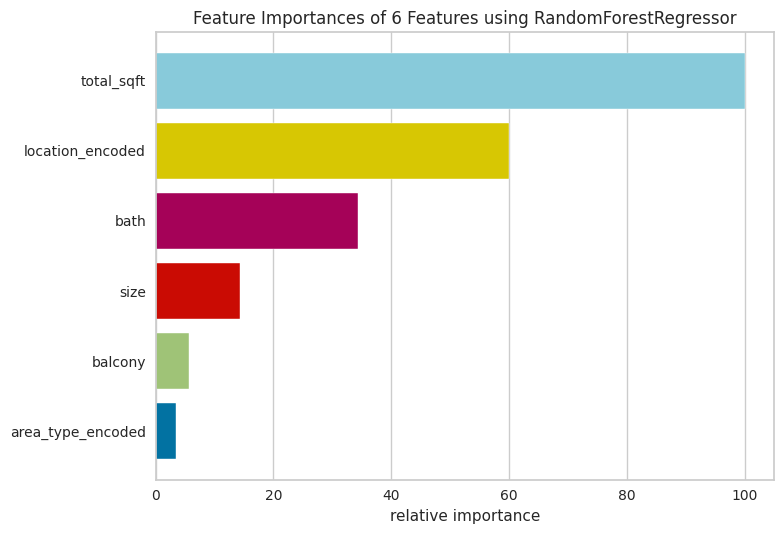

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.7, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


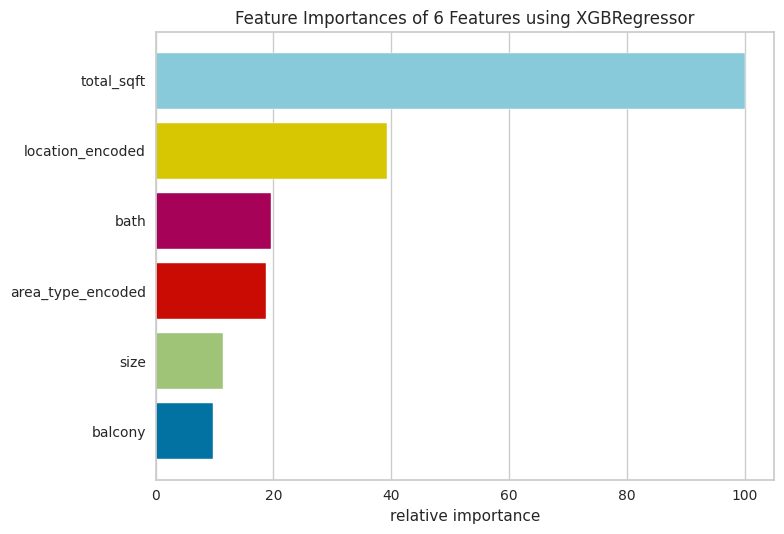

GradientBoostingRegressor(learning_rate=0.5)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


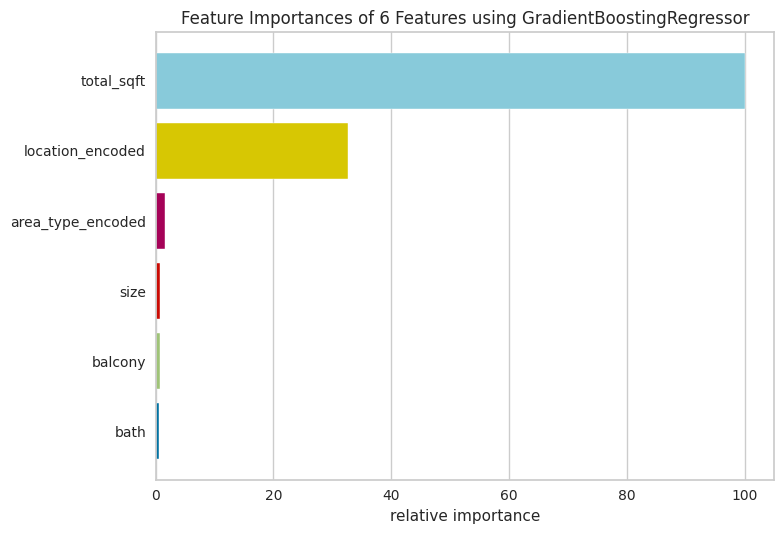

ExtraTreesRegressor(random_state=0)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


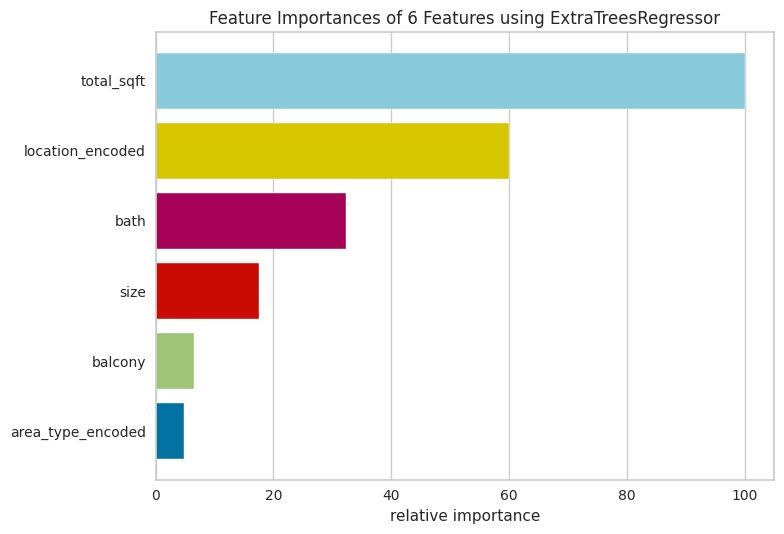

In [86]:
from yellowbrick.model_selection import FeatureImportances

estimator_importances = {}
for name, estimator in vr.named_estimators_.items():
    print(estimator)
    if hasattr(estimator, 'feature_importances_'):
        # Store feature importances
        estimator_importances[name] = estimator.feature_importances_
        # Create and show FeatureImportances visualizer
        visualizer = FeatureImportances(estimator, labels=X_train.columns)
        visualizer.fit(X_train, y_train)
        visualizer.show()
    else:
        print(f"Estimator {name} does not support feature importances.")

### Predicting Values

In [93]:
results

,index,R2,R2 -MinMaxScaler,R2 - StandardScaler
model,,,,
LinearRegression,0,0.713340,0.713340,0.713340
DecisionTree,1,0.739329,0.739381,0.739381
Voting Regressor,2,0.789385,-3.618993,-3.600831
Random Forest,3,0.791790,0.789643,0.790015
Voting Regressor,4,0.789188,-3.618993,-3.600831
Voting Regressor,5,0.790102,-3.618993,-3.600831
Voting Regressor,6,0.789381,0.739381,0.739381
GradientBoostingRegressor,7,0.768690,0.768928,0.769109
XG Boost,8,0.778817,0.778817,0.778817


In [99]:
import random
import warnings
warnings.filterwarnings("ignore")
                        
rand = random.randint(0, len(X_test) - 1)

print("Features:")
print(X_test.iloc[rand])
print("Actual Target Value:")
print(y_test.iloc[rand])

lr = LinearRegression()
lr.fit(X_train, y_train)
print("Linear Regression Prediction:")
print(lr.predict([X_test.iloc[rand]]))

dt = DecisionTreeRegressor(max_depth= 10, min_samples_leaf= 4, min_samples_split= 10)
dt.fit(X_train_ss, y_train)
print("Decision tree Prediction:")
print(dt.predict([X_test.iloc[rand]]))


rf = RandomForestRegressor(n_estimators= 200, max_depth = 15, max_features='sqrt')
rf.fit(X_train, y_train);
print("Random Forest Prediction:")
print(rf.predict([X_test.iloc[rand]]))


gbr = GradientBoostingRegressor(learning_rate=.1)
gbr.fit(X_train_mm, y_train)
print("Gradient Boosting Prediction:")
print(gbr.predict([X_test.iloc[rand]]))

xg = xgb.XGBRegressor(learning_rate = .5, n_estimators=50, verbosity = 0)
xg.fit(X_train, y_train)
print("XGBoost Prediction:")
print(xg.predict([X_test.iloc[rand]]))

vr = VotingRegressor([('dt', dt), ('knn', knn), ('lr', lr), ('rf', rf), ('xg', xg), ('gbr', gbr), ('etr', etr)])
vr.fit(X_train, y_train)
print("Voting Regressor Prediction:")
print(vr.predict([X_test.iloc[rand]]))

Features:
size                    3.000000
total_sqft           1450.000000
bath                    3.000000
balcony                 2.000000
location_encoded       58.500000
area_type_encoded      70.764672
Name: 9116, dtype: float64
Actual Target Value:
75.0
Linear Regression Prediction:
[72.85076807]
Decision tree Prediction:
[155.8]
Random Forest Prediction:
[66.41665226]
Extra Trees Prediction:
[66.9767]
Gradient Boosting Prediction:
[180.18998225]
XGBoost Prediction:
[67.49325]
Voting Regressor Prediction:
[67.92548514]
